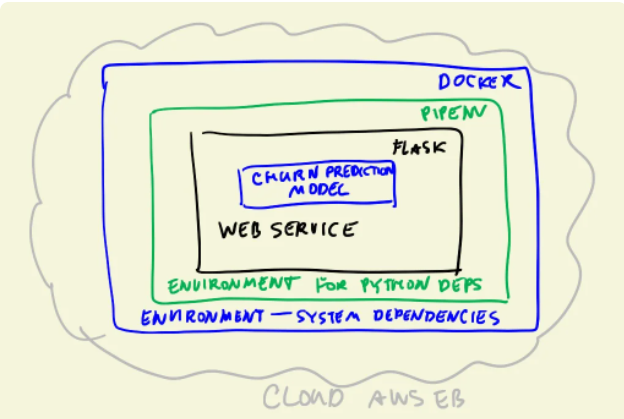

### Import Packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## Build the Model (00-BuildTheModel)

### Read and Preprocess the data

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

### Split the data into train/test/validation sets

In [3]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train_full = df_train_full.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

### Functions of Preprocessing/Train/Predict

#### Define Features Types

In [4]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

Before running the model some preprocessing was performed:
1. [DictVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) - [why?](https://www.kaggle.com/getting-started/109329)
In a nutshell, this method, vectorizes labeled observations regardless categorical features.

In [5]:
def train(df, y, C=1.0):
    # cat = df[categorical + numerical].to_dict(orient='rows') # Deprecated
    cat = df[categorical + numerical].to_dict('records')
    
    # DictVectorizer - notice that both categorical and numerical are an input
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict('records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

### Training

In [6]:
# Parameters of Logistic Regression Model
C = 0.5

y_train = df_train_full.churn.values
y_test = df_test.churn.values

dv, model = train(df_train_full, y_train, C = C)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858


### Save Model

In [11]:
output_file = f'model_C={C}.bin'
output_file

'model_C=0.5.bin'

In [12]:
import pickle 

with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

### Load Model

In [1]:
output_file = 'model_C=0.5.bin'

In [2]:
import pickle
with open(output_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [3]:
dv, model

(DictVectorizer(sparse=False), LogisticRegression(C=0.5, solver='liblinear'))

#### Predict new customer

In [17]:
customer = {
    'customerid': '8879-zkjof',
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'no',
    'dependents': 'no',
    'tenure': 41,
    'phoneservice': 'yes',
    'multiplelines': 'no',
    'internetservice': 'dsl',
    'onlinesecurity': 'yes',
    'onlinebackup': 'no',
    'deviceprotection': 'yes',
    'techsupport': 'yes',
    'streamingtv': 'yes',
    'streamingmovies': 'yes',
    'contract': 'one_year', # month-to-month,one_year
    'paperlessbilling': 'yes',
    'paymentmethod': 'bank_transfer_(automatic)',
    'monthlycharges': 79.85,
    'totalcharges': 3320.75
}

We get the probability of a given customer to churn:

In [19]:
def predict_single(customer, dv, model):
    X = dv.transform([customer])
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred[0]

In [20]:
predict_single(customer, dv, model)

0.0618756855983274

## Web services - Using Flask

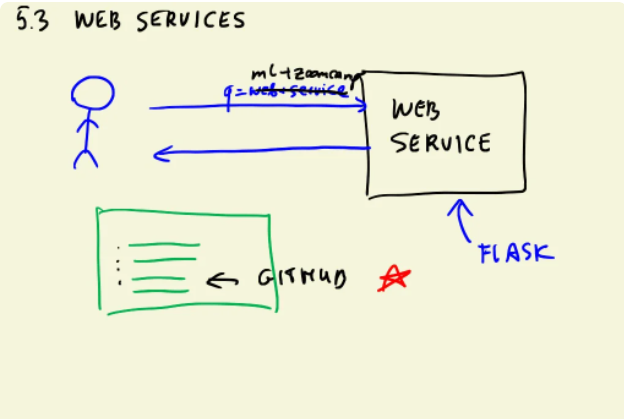

- [HTML processes explanation](https://www.w3schools.com/tags/ref_httpmethods.asp);
- [Main method](https://realpython.com/python-main-function/)
- [curl](https://phoenixnap.com/kb/curl-command) Ubuntu command line to comunicate with the web services

Steps:
1. Define a web service with Flask within a function - **Ping Function**
2. Run the webservice with `python ping.py`
3. Communicate with it using the method built, in our example: ``curl http://0.0.0.0:9696/ping``

### Function: flask_test (01-FlaskTest)

```python
from flask import Flask

app = Flask('test')


@app.route('/ping', methods=['GET'])
def ping():
    return "Pong"

# This function should live inside __main__ method
if __name__ == "__main__":
    app.run(debug=True, host='0.0.0.0', port=9696)
```

In [1]:
! python flask_test.py

 * Serving Flask app 'ping' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:9696
 * Running on http://192.168.1.133:9696 (Press CTRL+C to quit)
 * Restarting with stat
 * Debugger is active!
 * Debugger PIN: 658-672-761
^C


**While the webservice is up** - one can make a request to the methods built

In [3]:
! curl http://0.0.0.0:9696/ping

Pong

In [4]:
! curl http://localhost:9696/ping

Pong

**Note:** Since it is a 'GET' method we can also do it from a browser - [http://localhost:9696/ping](http://localhost:9696/ping)

## Serving the Churn Model with Flask

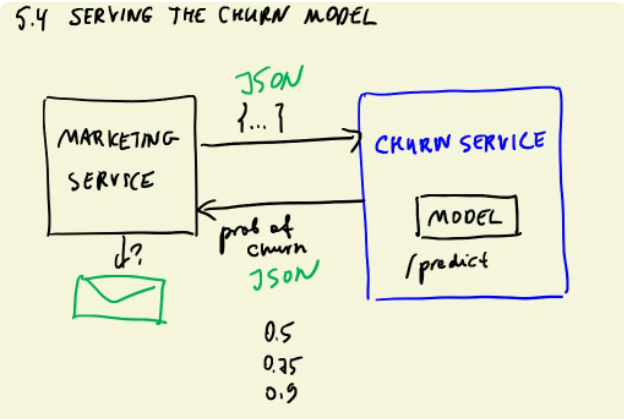

Flask assumes that we work with json files, so we need to use two special help function to convert it to dict, so python can perform their operation easier:
1. **request.get_json()** - to transform from json to python dictionary
    - Attention: To communicate with flask get_json substitute `'` by `"`
    
    
2. **jsonify**(result) - to transform python dictionary to json


To communicate with 'POST' method from flask, it is easier if we use a library named: **requests**

### Function: predict_service 

```python
import pickle
from flask import Flask
from flask import request
from flask import jsonify

C = 0.5
output_file = f'model_C={C}.bin'


with open(output_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)
    
app = Flask('churn')

# We change it here to POST method to give information about the customer
@app.route('/predict', methods=['POST'])
def predict_single():
    customer = request.get_json() # It will turn into a json file into a python dictionary

    ## We should put it in a separate function ##
    X = dv.transform([customer])
    y_pred = model.predict_proba(X)[0, 1]
    # Make decision in our service - to help the marketing team (they do not know which threshold to use)
    churn = y_pred >= 0.5
    #############################################

    # Our response it needs to be json so we need to prepare it as well
    result = {
        'churn_probability': float(y_pred), 
        'churn': bool(churn)
    }

    return jsonify(result)

# This function should live inside __main__ method
if __name__ == "__main__":
    app.run(debug=True, host='0.0.0.0', port=9696)
```

In [2]:
import requests # to communicate with 'POST' method

In [21]:
url = 'http://0.0.0.0:9696/predict'
customer = {
    "customerid": "8879-zkjof",
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "no",
    "dependents": "no",
    "tenure": 1,
    "phoneservice": "yes",
    "multiplelines": "no",
    "internetservice": "dsl",
    "onlinesecurity": "yes",
    "onlinebackup": "no",
    "deviceprotection": "yes",
    "techsupport": "yes",
    "streamingtv": "yes",
    "streamingmovies": "yes",
    "contract": "month-to-month", # month-to-month,one_year
    "paperlessbilling": "yes",
    "paymentmethod": "bank_transfer_(automatic)",
    "monthlycharges": 79.85,
    "totalcharges": 3320.75
}

Send a request to the post method:

In [14]:
requests.post(url, json=customer)

<Response [500]>

`TypeError: Object of type bool_ is not JSON serializable`

This is due to `numpy` format, so we need to change our result into a python `object`:

```python
    result = {
        'churn_probability': y_pred, 
        'churn': churn
    }
```

**Transformation:**
```python
    result = {
        'churn_probability': float(y_pred), 
        'churn': bool(churn)
    }
```

- Since we run our flask app in **debug mode** it detected the change and we do not need to restart the web service 
```python
if __name__ == "__main__":
    app.run(debug=True, host='0.0.0.0', port=9696)
```

In [15]:
requests.post(url, json=customer)

<Response [500]>

**<Response [200]>** - means that it was **successfully completed**. To get the actual value we need to add *.json()*

In [23]:
requests.post(url, json=customer).json()

{'churn': True, 'churn_probability': 0.5863950937170842}

In [22]:
response = requests.post(url, json=customer).json()
if response['churn'] == True:
    print('Sending promo email to %s' % (customer['customerid']))

Sending promo email to 8879-zkjof


### Do not use plain flask in Production - why? 

`WARNING: This is a development server. Do not use it in a production deployment.
 Use a production WSGI server instead.`

**Solution:** Use WSGI or gunicorn server --- `pip install gunicorn`
- **Note:** `gunicorn` will not run the `if __name__ == "__main__":` code line

**To run it with Gunicorn one needs to use the following command line:**
- `gunicorn --bind {host}:{port} {scrip_name}:{function_app}` -> `gunicorn --bind 0.0.0.0:9696 predict_service:app`

Now there is no warnings, and we can test it:

In [25]:
requests.post(url, json=customer).json()

{'churn': True, 'churn_probability': 0.5863950937170842}

In [26]:
response = requests.post(url, json=customer).json()
if response['churn'] == True:
    print('Sending promo email to %s' % (customer['customerid']))

Sending promo email to 8879-zkjof


## Python Virtual Environment: Pipenv

Personally, I prefer to use `venv` instead of `pipenv` to manage my virtual environments. Although python community advices to use `pipenv`. In order to use `pipenv` please follow this [link](https://www.youtube.com/watch?v=BMXh8JGROHM&list=PL3MmuxUbc_hIhxl5Ji8t4O6lPAOpHaCLR&index=57) otherwise if you prefer to use `venv` use this [git repository](https://github.com/LDSSA/batch5-students) README file to built your virtual environments.

## Environment Management: Docker (02-ToDeliverWithDocker)

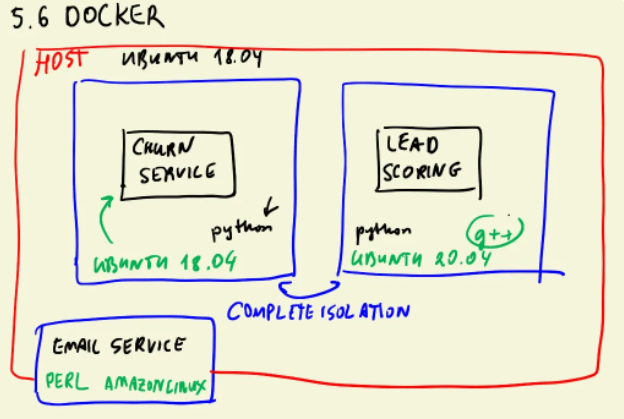

More isolation than using virtual environments approach. With docker we can put each service/application in a different container (blue boxes), which are completed isolated from each other. 

Then we have a host (which I like to call a docker - red box) that can control that containers. Further explanations can be found [here](https://docs.docker.com/get-started/overview/)

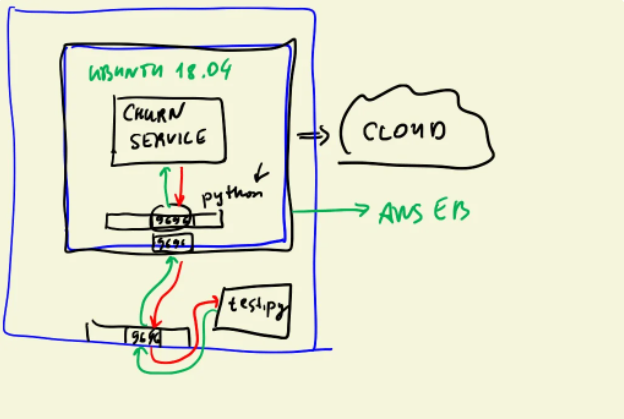

One of the big advantage is that we can take one of our services and we can easily deploy it in the cloud. The container already has everything we need, so we don't need to worry about any dependency. Also, whatever we do in an image does not affect any of environments that we have in the host.

#### Running a python image with docker

In [dockerhub](https://hub.docker.com/) we can find different kinds of images, which will help us to create a container with the specifications that we need.

In this exercise we will use python-slim from [this repository](https://github.com/docker-library/python/blob/f871d0435e7f35a693fa1b60aa159e6a1a4c6a2e/3.8/slim-bullseye/Dockerfile) of dockerhub.

How to install docker and give sudo permissions [here](https://www.digitalocean.com/community/tutorials/how-to-install-and-use-docker-on-ubuntu-20-04-pt)

TAG: **3.8.12-slim** - to install the docker image

`sudo docker run -it --rm --entrypoint=bash python:3.8.12-slim`

terminology
1. `--rm`: after using it we want to remove from our machine
2. `-it`: to have access to terminal
3. `--entrypoint=bash`: to enter directly into the terminal (bash), if we don't specify this, it will go directly to python

Anything we want to do in a docker image, we can define on a **[Dockerfile](https://docs.docker.com/engine/reference/builder/)** which contains instructions of what we want to do in that image

#### Dockerfile:
```docker
# First we should define the basic image
FROM python:3.8.12-slim

# Add things on top of this image
RUN pip install pipenv

# Define a working directory inside our docker image - (similar to cd command)
WORKDIR /app
# Copy the files that we need, the last argument in the list
# referes to the place were the files are going to be copy to
COPY ["requirements.txt", "./"]

# Install the requirements used in the development stage
RUN pip install -r requirements.txt

# Copy other dependencies for our image
COPY ["predict_service.py", "model_C=0.5.bin", "./"]
```

**Now** we can **build our imagem using the Dockerfile**:

`sudo docker build -t zoomcamp-test .`

terminology:
1. `zoomcamp-test`: is the name of our image, will be use to **run the docker**
2. `.`: is to copy to the working directory

**The image is build and one can use the following command line to run and work in the docker image**:
- `sudo docker run -it --rm --entrypoint=bash zoomcamp-test:latest`

terminology:
1. `latest`: is the tag, but we can use it or not, depending if we have different version of the image

We can now run again the web service in our docker image: `gunicorn --bind 0.0.0.0:9696 predict_service:app`

**The problem** is that we cannot yet access this port because we need to exposed it from the **docker image** to our **host**. Which is referred to this part of the process:

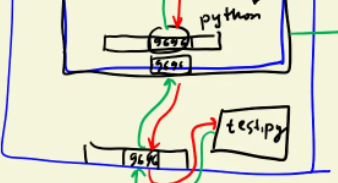

This process is named: **Port Mapping**, which can be done following these steps:

**1.** Add the following lines of code to our Dockerfile, to expose the port to our localhost:

```docker
# EXPOSE THE PORT TO BE CONSUMED BY THE HOST (YOUR COMPUTER)
EXPOSE 9696

# SET THE ENTRYPOINT AS WELL
ENTRYPOINT ["gunicorn", "--bind=0.0.0.0:9696", "predict_service:app"]
```

**2.** Then build the image again with `sudo docker build -t zoomcamp-test .`


**3.** And run it with: `sudo docker run -it --rm zoomcamp-test:latest` - notice that there is no need to add the entrypoint now

**4** It is supposed to give an error since it does not have the path from port of the host and the container, for that one should had this to the command line:
- `sudo docker run -it --rm 9696:9696 zoomcamp-test:latest`
- `sudo docker run -it --rm {container_port}:{localmachine_port} zoomcamp-test:latest`

**5.** After this we can make the request to the web service running in the docker

In [35]:
import requests # to communicate with 'POST' method

In [55]:
url = 'http://0.0.0.0:9696/predict'
customer = {
    "customerid": "8879-zkjof",
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "no",
    "dependents": "no",
    "tenure": 1,
    "phoneservice": "yes",
    "multiplelines": "no",
    "internetservice": "dsl",
    "onlinesecurity": "yes",
    "onlinebackup": "no",
    "deviceprotection": "yes",
    "techsupport": "yes",
    "streamingtv": "yes",
    "streamingmovies": "yes",
    "contract": "month-to-month", # month-to-month,one_year
    "paperlessbilling": "yes",
    "paymentmethod": "bank_transfer_(automatic)",
    "monthlycharges": 79.85,
    "totalcharges": 3320.75
}

In [56]:
requests.post(url, json=customer).json()

{'churn': True, 'churn_probability': 0.5863950937170842}

In [57]:
response = requests.post(url, json=customer).json()
if response['churn'] == True:
    print('Sending promo email to %s' % (customer['customerid']))

Sending promo email to 8879-zkjof


The connection and request were well made

## Deployment to the cloud: AWS Elastic Beanstalk (optional) - (02-ToDeliverInAWS)

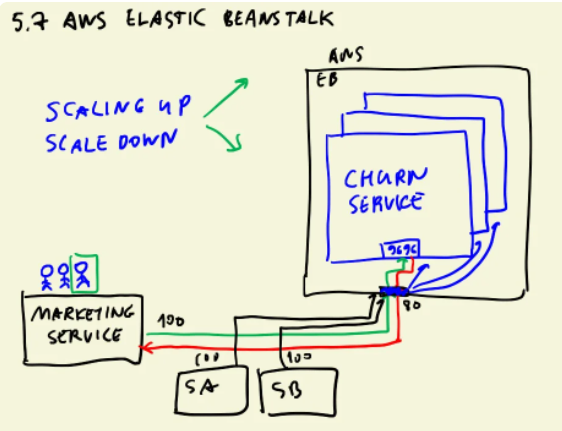

1. Installing the eb cli 
     
     - In your virtual environment run `pip install awsebcli`
     - If your using the `virtualenv` mode, please `freeze` it and rewrite the `requirements.txt` file
     

2. Running eb locally
3. Deploying the model

First create a aws account and a new user using this [link](https://mlbookcamp.com/article/aws)

### Create a Amazon Elastic Beanstalk

[Amazon Elastic Beanstalk](https://aws.amazon.com/elasticbeanstalk/?nc1=h_ls) : Is elastic enough to scale and add more capability for a service to reply all the requests, in a given time.

Check regions in this [link](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-regions-availability-zones.html#concepts-regions)

#### Run Locally

1. Run this command to init the eb:
- `eb init -p docker -r eu-west-3 churn_serving`
2. Before it goes up, we should test it locally (so we don't pay unnecessary money):
- `eb local run --port 9696`
3. After this we can make a request to our docker image that lives inside **ed aws - still locally**

In [58]:
import requests # to communicate with 'POST' method

In [59]:
url = 'http://0.0.0.0:9696/predict'
customer = {
    "customerid": "8879-zkjof",
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "no",
    "dependents": "no",
    "tenure": 1,
    "phoneservice": "yes",
    "multiplelines": "no",
    "internetservice": "dsl",
    "onlinesecurity": "yes",
    "onlinebackup": "no",
    "deviceprotection": "yes",
    "techsupport": "yes",
    "streamingtv": "yes",
    "streamingmovies": "yes",
    "contract": "month-to-month", # month-to-month,one_year
    "paperlessbilling": "yes",
    "paymentmethod": "bank_transfer_(automatic)",
    "monthlycharges": 79.85,
    "totalcharges": 3320.75
}

In [60]:
requests.post(url, json=customer).json()

{'churn': True, 'churn_probability': 0.5863950937170842}

In [61]:
response = requests.post(url, json=customer).json()
if response['churn'] == True:
    print('Sending promo email to %s' % (customer['customerid']))

Sending promo email to 8879-zkjof


### To run in the cloud

`eb create churn-serving-env` - To create an environment

In [58]:
import requests # to communicate with 'POST' method

In [64]:
host = '' # url that the service was deployed
url = f'http://{host}/predict' # We don't need the port, eb maps the 9696 to port 80 (server port)
customer = {
    "customerid": "8879-zkjof",
    "gender": "female",
    "seniorcitizen": 10,
    "partner": "no",
    "dependents": "no",
    "tenure": 1,
    "phoneservice": "yes",
    "multiplelines": "no",
    "internetservice": "dsl",
    "onlinesecurity": "yes",
    "onlinebackup": "no",
    "deviceprotection": "yes",
    "techsupport": "yes",
    "streamingtv": "yes",
    "streamingmovies": "yes",
    "contract": "month-to-month", # month-to-month,one_year
    "paperlessbilling": "yes",
    "paymentmethod": "bank_transfer_(automatic)",
    "monthlycharges": 79.85,
    "totalcharges": 3320.75
}

In [65]:
requests.post(url, json=customer).json()

{'churn': True, 'churn_probability': 0.908769081127575}

In [66]:
response = requests.post(url, json=customer).json()
if response['churn'] == True:
    print('Sending promo email to %s' % (customer['customerid']))

Sending promo email to 8879-zkjof


### DO NOT FORGET TO TERMINATE THE ENVIRONMENT

**ATTENTION:** This environment was created without any security, and because of that is open to the world. Everyone that has the url can make requests to it.

`eb terminate churn-serving-env` - To terminate the environment

All rights reserved to [DataTalks.Club](https://datatalks.club/)